# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [391]:
# %conda install wget

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-10-02 22:32:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M   823KB/s    in 4m 36s  

2022-10-02 22:37:26 (747 KB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [25]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [26]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [27]:
#Ridge
model = Ridge()
model.fit(X_train, y_train)
print(
    np.round(mean_squared_error(y_test, model.predict(X_test), squared=False), 2))

9.51


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [28]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [29]:
set_random_seed(42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=30
)

In [30]:
scaler_x= StandardScaler()
scaler_y= StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)



In [31]:
class RegressionDataset(torch.utils.data.Dataset):
    """Our dataset"""
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]

In [32]:
#Гиперпарамметры
EPOCHS = 13
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_FEATURES = X_train.shape[1]

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [33]:
train_dataset =  RegressionDataset(torch.from_numpy(X_train).to(torch.float), torch.from_numpy(y_train).to(torch.float))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)

val_dataset =  RegressionDataset(torch.from_numpy(X_val).to(torch.float), torch.from_numpy(y_val).to(torch.float))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

test_dataset =  RegressionDataset(torch.from_numpy(X_test).to(torch.float), torch.from_numpy(y_test).to(torch.float))
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [34]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [35]:
model = nn.Sequential(
nn.Linear(NUM_FEATURES, 600),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(600, 90),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(90, 1)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.5, patience=2, mode="min", verbose=True
        )


In [36]:
import wandb

# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
# инициализируем проект
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [14]:
# инициализируем проект
wandb.init(project="Hw-1_1")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

In [37]:
def train(model, optimizer, criterion, train_loader, scale, device="cuda:0"):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''    
    train_epoch_loss = 0
    model = model.to(device).train()
   
    for X_train_batch, y_train_batch in tqdm(train_loader):
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device).to(torch.float32)
            y_train_pred = model(X_train_batch).to(torch.float32) 
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        


            train_epoch_loss += train_loss.item()

    Loss = np.sqrt(train_epoch_loss/len(train_loader)) * scale
    return Loss


        
def val(model, criterion, val_loader, scale, device="cuda:0"):       
        # VALIDATION    
        with torch.no_grad():
            val_epoch_loss = 0
            model.eval() 
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch.to(device).to(torch.float32) 

                y_val_pred = model(X_val_batch).to(torch.float32) 
                val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
                val_epoch_loss += val_loss.item()

        Loss =  np.sqrt(val_epoch_loss/len(val_loader)) * scale
        return Loss



def test(model, criterion, test_loader, scale, device="cuda:0"):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    # TEST
    test_epoch_loss = 0   
    model.eval()
    predicts = []
    for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device).to(torch.float32) 
            
                y_test_pred = model(X_test_batch).to(torch.float32) 
                predicts.append(y_test_pred)     
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
                test_epoch_loss += test_loss.item()
    Loss = np.sqrt(test_epoch_loss/len(test_loader)) * scale
    return Loss, predicts

In [38]:
def rabotai(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    test_data_loader,
    optimizer,
    criterion,
    scheduler,
    scale,
    device="cuda:0"
):

    loss_stats = {
        "train": [],
        "val": [],
        "test": []
    }
    print("POEXALI")
            
    for epoch in range(epochs):
        train_metrics = train(model = model, optimizer = optimizer, criterion = criterion, train_loader = train_data_loader, scale = scale, device = device)
        loss_stats["train"].append(train_metrics)
        # Val step

        with torch.no_grad():
            val_metrics = val(model, criterion, val_loader, scale, device)

        # Save val losses
            loss_stats["val"].append(val_metrics)
        

        # Test step

        with torch.no_grad():
            test_metrics, *_ = test(model, criterion, test_loader, scale, device)

        # Save test losses

            loss_stats["test"].append(test_metrics)
            
            wandb.log({"loss_train": train_metrics,
                   "loss_val": val_metrics,
                   "loss_test": test_metrics})
                   
        scheduler.step(val_metrics)
        print(f'Epoch {epoch+1:3}: | Train Loss: {train_metrics:.5f} | Val Loss: {val_metrics:.5f} | Test Loss: {test_metrics:.5f}')

        
    train_val_test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    plt.figure(figsize=(15,9))
    sns.lineplot(data=train_val_test_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val-Test Loss/Epoch')   
        



POEXALI


  0%|          | 0/6521 [00:00<?, ?it/s]

/var/folders/7b/_0j65qyd6_l801khvk_jh2yh0000gn/T/ipykernel_664/2466134966.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]


Epoch   1: | Train Loss: 9.30156 | Val Loss: 8.88059 | Test Loss: 8.98160


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   2: | Train Loss: 8.95438 | Val Loss: 8.76666 | Test Loss: 8.89590


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   3: | Train Loss: 8.84413 | Val Loss: 8.71713 | Test Loss: 8.86584


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   4: | Train Loss: 8.76410 | Val Loss: 8.66407 | Test Loss: 8.81841


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   5: | Train Loss: 8.71989 | Val Loss: 8.64006 | Test Loss: 8.80514


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   6: | Train Loss: 8.66990 | Val Loss: 8.61361 | Test Loss: 8.79331


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   7: | Train Loss: 8.64433 | Val Loss: 8.59619 | Test Loss: 8.81662


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   8: | Train Loss: 8.60095 | Val Loss: 8.58839 | Test Loss: 8.77463


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch   9: | Train Loss: 8.57311 | Val Loss: 8.55260 | Test Loss: 8.77982


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch  10: | Train Loss: 8.54688 | Val Loss: 8.54885 | Test Loss: 8.77016


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch  11: | Train Loss: 8.51748 | Val Loss: 8.53968 | Test Loss: 8.75935


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch  12: | Train Loss: 8.49544 | Val Loss: 8.51521 | Test Loss: 8.75789


  0%|          | 0/6521 [00:00<?, ?it/s]

Epoch  13: | Train Loss: 8.46477 | Val Loss: 8.50509 | Test Loss: 8.74984


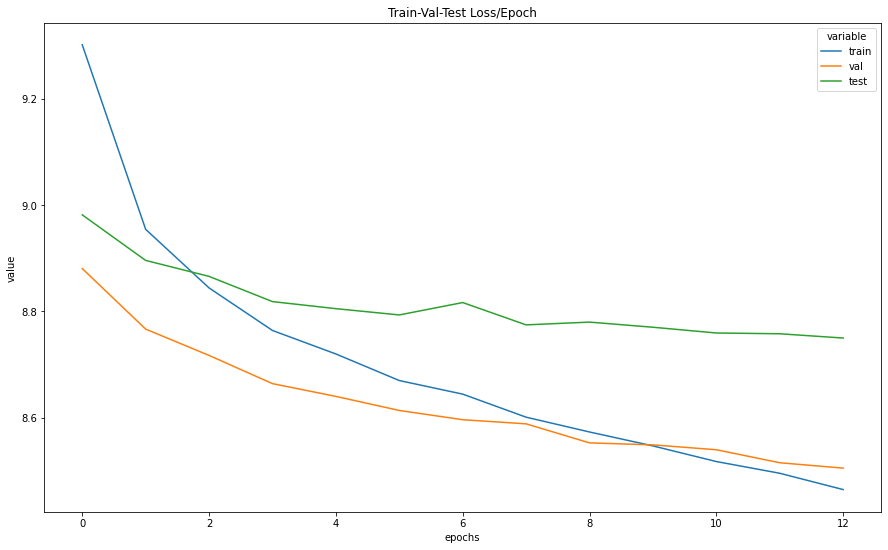

In [39]:
set_random_seed(42)
rabotai(
    model,
    EPOCHS,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    criterion,
    scheduler,
    *scaler_y.scale_,
    device = device
)


In [40]:
loss, pred = test(model, criterion, test_loader, scaler_y.scale_[0], device)

/var/folders/7b/_0j65qyd6_l801khvk_jh2yh0000gn/T/ipykernel_664/2466134966.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]


In [41]:
pred

[tensor([[ 0.1867],
         [ 0.3855],
         [ 0.2153],
         [ 0.5114],
         [ 0.5293],
         [ 0.2197],
         [ 0.3676],
         [ 0.0393],
         [-0.1018],
         [ 0.3306],
         [ 0.5687],
         [ 0.6134],
         [ 0.5381],
         [ 0.4846],
         [ 0.4369],
         [ 0.5823],
         [ 0.6459],
         [ 0.4727],
         [ 0.7180],
         [ 0.7618],
         [ 0.6873],
         [ 0.5250],
         [ 0.7007],
         [ 0.6747],
         [ 0.5875],
         [ 0.4165],
         [ 0.7579],
         [ 0.6149],
         [ 0.2546],
         [ 0.4753],
         [ 0.3802],
         [ 0.1144],
         [ 0.2666],
         [-0.5209],
         [ 0.3285],
         [-0.0408],
         [ 0.2620],
         [ 0.4984],
         [ 0.4196],
         [-0.2835],
         [ 0.7922],
         [ 0.8403],
         [ 0.7378],
         [ 0.1275],
         [ 0.6936],
         [ 0.7520],
         [ 0.6760],
         [ 0.4742],
         [ 0.6063],
         [ 0.7861],


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [408]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
# https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93
# https://github.com/allenai/allennlp/issues/3922
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md#mlp-for-regression-with-pytorch---full-code-example

In [ ]:
#1) sweet-bush-16 : 
# https://wandb.ai/dedpe/Hw-1_1/reports/loss_test-22-10-09-00-26-19---VmlldzoyNzYxODY1?accessToken=lqghtundrvmx25k8jc5mdhqlibcqm0ibu29769lec8r24vlyvc87xpcs4g55uirt
nn.Linear(NUM_FEATURES, 300),
nn.ReLU(),
nn.Dropout(0.2),
nn.Linear(300, 100),
nn.ReLU(),
nn.Linear(100, 1)
#Гиперпарамметры
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 5e-4
NUM_FEATURES = X_train.shape[1]

# 2) chocolate-dust-20:
# https://wandb.ai/dedpe/Hw-1_1/reports/loss_test-22-10-09-00-23-18---VmlldzoyNzYxODYw?accessToken=pd2meomn3z3rr0qm6lij22jnl4fp9upxlhw4i1sa8f30g01x1xosf505emz4slte
nn.Linear(NUM_FEATURES, 300),
nn.ReLU(),
nn.Linear(300, 100),
nn.ReLU(),
nn.Linear(100, 1)

#Гиперпарамметры
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_FEATURES = X_train.shape[1]





# 3) fresh-lion-31 :
#  https://wandb.ai/dedpe/Hw-1_1/reports/loss_test-22-10-09-02-00-57---VmlldzoyNzYyMDkx?accessToken=gcct368drkw6qdishy546dtwzk99pivm3r9hucq4ozi0v17q5yw5741wuf8abtq7

model = nn.Sequential(
nn.Linear(NUM_FEATURES, 600),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(600, 90),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(90, 1)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.5, patience=2, mode="min", verbose=True
        )

#Гиперпарамметры
EPOCHS = 13
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_FEATURES = X_train.shape[1]

Чтобы написать сие творение, я вдохновлялся ссылками, указанными в задании, а также ниже в ячейке, очень много времени ушло на перепись всего этого в 3 функции, чтобы все нормально работало, неконфликтовало.

Затем я брал по принципу - много, долго - хорошо, с этим я чуть не сел в лужу, потому что ничего хорошего не получалось, либо долгий прогресс, маленький.
Понял, что надо пробовать легкое, взял пример 2), очевидно надо было ставить ограничитель, поставил 1), видел, что все равно прокакивает, дальше проводил точечные эксперементы, меняя батч, меняя шаг, количество эпох. Понял, что шаг нужен маленький, количество эпох небольшое, добавил еще один дроп, а дальше просто перебирал батч с дропом, на 13 эпохе ждал успех 3)




 1) sweet-bush-16 :
Получилось 8.81, с ограничением dropout, скачет заметно ниже



2) chocolate-dust-20:
Модель очень сильно скачет, быстро обучается, но очевидно нужен ограничитель, 
пробую batchnorm, dropout, с ним модель обучается медленнее, но стабильнее, все равно скачет сильно,




3)fresh-lion-31 :
ПОСЛЕ 1-2 тестов, стало понятно, что модель просто проходит момент минимума test_loss, поэтому надо было уменьшать 'масштаб',
 поставил батч 32, шаг 1e-4, дропаут повысил, все равно проскок, наконец последняя ставка - наш тест, все идеально зашло тютелька в тютельку
 
